In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [65]:
df = pd.read_csv(r'C:\Users\masha\Downloads\cleaned_and_balanced_complaints_small.csv')

In [66]:
df_no_text = df.drop(columns=['Consumer complaint narrative'])

In [67]:
print(df_no_text)

     Date received                                            Product  \
0       2017-07-28                        Credit card or prepaid card   
1       2022-06-16  Credit reporting, credit repair services, or o...   
2       2023-01-22                                    Debt collection   
3       2017-04-21                            Bank account or service   
4       2022-03-20  Credit reporting, credit repair services, or o...   
...            ...                                                ...   
4995    2021-11-16                        Checking or savings account   
4996    2022-09-09  Credit reporting, credit repair services, or o...   
4997    2022-12-15  Credit reporting, credit repair services, or o...   
4998    2020-08-10                                           Mortgage   
4999    2023-10-19  Credit reporting or other personal consumer re...   

                                                  Issue  \
0                               Trouble using your card   
1    

In [68]:
print(len(df_no_text))

5000


In [69]:
product_counts = df['Product'].value_counts().nunique()
print(product_counts)

18


In [70]:
issue_counts = df['Issue'].value_counts().nunique()
print(issue_counts)

53


In [71]:
public_response_counts = df['Company public response'].value_counts().nunique()
print(public_response_counts)

11


In [72]:
consumer_response_counts = df['Company response to consumer'].value_counts().nunique()
print(consumer_response_counts)

4


In [73]:
from workalendar.usa import UnitedStates
from datetime import datetime


In [74]:
# Initialize the calendar for the United States
cal = UnitedStates()

In [75]:
df['Date received'] = pd.to_datetime(df['Date received'])
df['Date sent to company'] = pd.to_datetime(df['Date sent to company'])

# Function to calculate business days
def calculate_business_days(row):
    return cal.get_working_days_delta(row['Date received'].date(), row['Date sent to company'].date())

# Apply the function to each row and create a new column
df["Business Days"] = df.apply(calculate_business_days, axis=1)

print(df)


     Date received                                            Product  \
0       2017-07-28                        Credit card or prepaid card   
1       2022-06-16  Credit reporting, credit repair services, or o...   
2       2023-01-22                                    Debt collection   
3       2017-04-21                            Bank account or service   
4       2022-03-20  Credit reporting, credit repair services, or o...   
...            ...                                                ...   
4995    2021-11-16                        Checking or savings account   
4996    2022-09-09  Credit reporting, credit repair services, or o...   
4997    2022-12-15  Credit reporting, credit repair services, or o...   
4998    2020-08-10                                           Mortgage   
4999    2023-10-19  Credit reporting or other personal consumer re...   

                                                  Issue  \
0                               Trouble using your card   
1    

In [76]:
print(df['Business Days'].describe())

count    5000.000000
mean        4.668200
std         9.212876
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max       151.000000
Name: Business Days, dtype: float64


In [77]:
print(len((df[df['Business Days'] == 0])))

2042


In [78]:
print(len((df[df['Business Days'] == 1])))
print(len((df[df['Business Days'] == 2])))
print(len((df[df['Business Days'] == 3])))
print(len((df[df['Business Days'] == 4])))
print(len((df[df['Business Days'] == 5])))
print(len((df[df['Business Days'] == 6])))


649
435
322
199
160
86


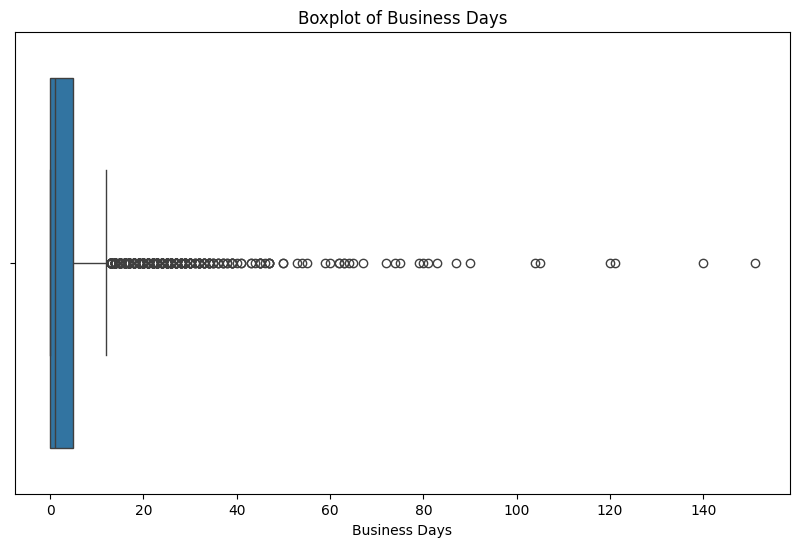

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of 'Business Days'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Business Days'])
plt.title('Boxplot of Business Days')
plt.show()

We are ignoring outliers for now

In [80]:
'''
# Remove outliers, decide how we're handling outliers
Q1 = df['Business Days'].quantile(0.25)
Q3 = df['Business Days'].quantile(0.75)

IQR = Q3 - Q1  # Corrected calculation for IQR

print(Q1)
print(Q3)
print(IQR)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the data to remove outliers
df_clean = df[(df['Business Days'] >= lower_bound) & (df['Business Days'] <= upper_bound)]

# Check the resulting statistics
print(df_clean['Business Days'].mean())
print(df_clean['Business Days'].std())
'''

"\n# Remove outliers, decide how we're handling outliers\nQ1 = df['Business Days'].quantile(0.25)\nQ3 = df['Business Days'].quantile(0.75)\n\nIQR = Q3 - Q1  # Corrected calculation for IQR\n\nprint(Q1)\nprint(Q3)\nprint(IQR)\n\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\n# Filter the data to remove outliers\ndf_clean = df[(df['Business Days'] >= lower_bound) & (df['Business Days'] <= upper_bound)]\n\n# Check the resulting statistics\nprint(df_clean['Business Days'].mean())\nprint(df_clean['Business Days'].std())\n"

Current method of removing outliers leaves only 0s, so this in invalid, need to come up with a better way to remove outliers.

In [81]:
print(df[['Date received', 'Date sent to company', 'Business Days', 'Timely response?']])

     Date received Date sent to company  Business Days Timely response?
0       2017-07-28           2017-07-28              0              Yes
1       2022-06-16           2022-06-22              4              Yes
2       2023-01-22           2023-02-14             17              Yes
3       2017-04-21           2017-04-21              0              Yes
4       2022-03-20           2022-03-20              0              Yes
...            ...                  ...            ...              ...
4995    2021-11-16           2021-11-17              1              Yes
4996    2022-09-09           2022-09-09              0              Yes
4997    2022-12-15           2022-12-16              1              Yes
4998    2020-08-10           2020-08-18              6              Yes
4999    2023-10-19           2023-10-19              0              Yes

[5000 rows x 4 columns]


In [82]:
no_df = df[(df['Timely response?'] == 'No')]
print(len(no_df))

yes_df = df[(df['Timely response?'] == 'Yes')]
print(len(yes_df))


77
4923


In [83]:
print("Statistics for 'Yes':")
print(yes_df['Business Days'].describe())
print("\nStatistics for 'No':")
print(no_df['Business Days'].describe())

Statistics for 'Yes':
count    4923.000000
mean        4.624213
std         9.183895
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max       151.000000
Name: Business Days, dtype: float64

Statistics for 'No':
count    77.000000
mean      7.480519
std      10.601155
min       0.000000
25%       2.000000
50%       3.000000
75%      11.000000
max      72.000000
Name: Business Days, dtype: float64


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [85]:
from dython.nominal import associations


In [86]:
df_timely_response = df[['Product','Issue', 'Company public response', 'Company response to consumer', 'Timely response?']]

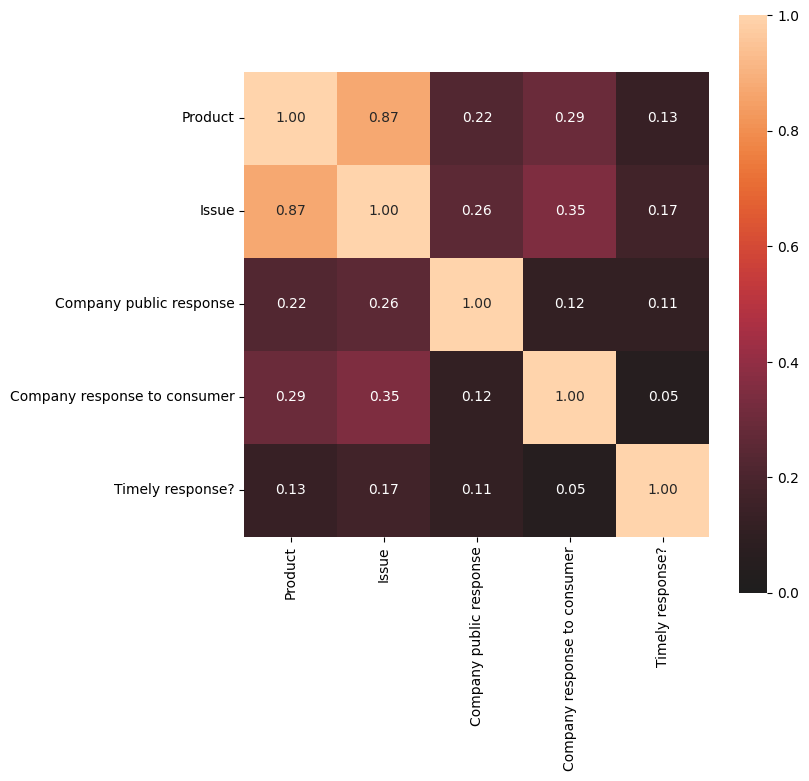

{'corr':                                Product     Issue  Company public response  \
 Product                       1.000000  0.869248                 0.221934   
 Issue                         0.869248  1.000000                 0.257098   
 Company public response       0.221934  0.257098                 1.000000   
 Company response to consumer  0.294712  0.350312                 0.115133   
 Timely response?              0.125438  0.171080                 0.112543   
 
                               Company response to consumer  Timely response?  
 Product                                           0.294712          0.125438  
 Issue                                             0.350312          0.171080  
 Company public response                           0.115133          0.112543  
 Company response to consumer                      1.000000          0.051474  
 Timely response?                                  0.051474          1.000000  ,
 'ax': <Axes: >}

In [87]:
associations(df_timely_response)


Pipeline to predict response time in buisiness days using issue, company public response, company response to consumer

In [88]:
df_response_time = df[['Issue', 'Company public response', 'Company response to consumer', 'Business Days']]

In [89]:
# One-hot encode categorical columns
"""
Product #need to actually remove Product because Issues are unique 
Issue
Company public response
Company response to consumer
"""


'\nProduct #need to actually remove Product because Issues are unique \nIssue\nCompany public response\nCompany response to consumer\n'

In [90]:
columns_to_encode = ['Issue', 'Company public response', 'Company response to consumer']

In [108]:
df_response_time_encoded = pd.get_dummies(df_response_time, columns=columns_to_encode).astype(int)

In [109]:
print(df_response_time_encoded.head())

   Business Days  Issue_APR or interest rate  \
0              0                           0   
1              4                           0   
2             17                           0   
3              0                           0   
4              0                           0   

   Issue_Account opening, closing, or management  Issue_Advertising  \
0                                              0                  0   
1                                              0                  0   
2                                              0                  0   
3                                              1                  0   
4                                              0                  0   

   Issue_Advertising and marketing  \
0                                0   
1                                0   
2                                0   
3                                0   
4                                0   

   Issue_Advertising and marketing, including promotion

In [110]:
# Define features (X) and target (y)
X = df_response_time_encoded.drop(['Business Days'], axis=1)
y = df_response_time_encoded['Business Days']

# Split the data into train, test and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [94]:
y_train.value_counts()

Business Days
0      1237
1       375
2       254
3       183
4       119
5       116
8        62
7        53
11       52
6        51
12       51
13       49
9        47
15       37
10       33
17       26
14       26
16       22
20       21
22       18
26       16
18       15
24       14
19       13
25       12
23       12
21       11
28        7
27        6
30        6
33        5
39        4
34        4
45        4
32        3
36        3
29        3
35        2
47        2
37        2
43        2
38        2
41        2
31        2
120       1
90        1
59        1
53        1
64        1
63        1
67        1
60        1
62        1
65        1
83        1
151       1
105       1
87        1
79        1
54        1
Name: count, dtype: int64

In [95]:
from sklearn.ensemble import GradientBoostingRegressor


In [96]:
# Initialize Gradient Boosting Classifier
gb = GradientBoostingRegressor(random_state=42)

# Define hyperparameters to tune


In [97]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

In [98]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)


In [99]:
# Fit the model
print("Tuning hyperparameters with GridSearchCV...")
grid_search.fit(X_train, y_train)

Tuning hyperparameters with GridSearchCV...
Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\masha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [100]:
# Best parameters
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}


In [101]:
# Evaluate on validation set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# Compute evaluation metrics
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 5.3220
Mean Squared Error (MSE): 76.5776
Root Mean Squared Error (RMSE): 8.7509
R² Score: 0.0520


In [111]:
df_response_time_encoded['Speedy'] = df_response_time_encoded['Business Days'].apply(lambda x: 1 if x == 0 else 0)


In [113]:
print(df_response_time_encoded)

      Business Days  Issue_APR or interest rate  \
0                 0                           0   
1                 4                           0   
2                17                           0   
3                 0                           0   
4                 0                           0   
...             ...                         ...   
4995              1                           0   
4996              0                           0   
4997              1                           0   
4998              6                           0   
4999              0                           0   

      Issue_Account opening, closing, or management  Issue_Advertising  \
0                                                 0                  0   
1                                                 0                  0   
2                                                 0                  0   
3                                                 1                  0   
4                

In [115]:
X = df_response_time_encoded.drop(columns=['Business Days', 'Speedy'])  # Drop unnecessary columns
y = df_response_time_encoded['Speedy']  # Our target variable


In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = gb_clf.predict(X_test)

In [118]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       887
           1       0.68      0.66      0.67       613

    accuracy                           0.73      1500
   macro avg       0.72      0.72      0.72      1500
weighted avg       0.73      0.73      0.73      1500


Confusion Matrix:
 [[694 193]
 [207 406]]
